In [1]:
import matplotlib.pyplot as plt
import wordcloud
import logging
import collections
import re
import nltk
import pandas as pd
import numpy as np
from PIL import Image

#Tokenizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

logger = logging.getLogger('FraudEmails')

#Minimum occurrence of a word to appear in the WordCloud
frequency = 100
#Number of words in WordCloud
numb_of_words = 400

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jseme\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jseme\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
#Open and convert file to string
try:
    with open('../data/fraudulent_emails.txt','r') as file:
        text = file.read()
except Exception as e:
    logger.error('Process failed with error: '+repr(e))
finally:
    file.close()



In [3]:
#Delete everything between From r [.*?] Status: ?O
emails = re.sub('From.*?Status: ?O','',text,flags=re.DOTALL)

In [4]:
#Convert to lower case
emails = emails.lower()

In [5]:
#Tokenize into string and remove stop words (the, a, on...)
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
tokens = tokenizer.tokenize(emails)
emailWordList = list(filter(lambda word: word not in nltk.corpus.stopwords.words('english'), tokens))

In [6]:
#Remove anything less than two characters
emailWordList = list(filter(lambda word: len(word)>2, emailWordList))

In [7]:
#HTML tags modified from https://www.w3schools.com/TAGS/default.ASP
htmldf = pd.read_csv('../data/html_tags.txt', sep='\t').dropna()
htmldf['Tag'] = htmldf['Tag'].str.strip()
htmldf.head()

,Tag,Description
0,<!--...-->,Defines a comment
1,<!DOCTYPE>,Defines the document type
2,<a>,Defines a hyperlink
3,<abbr>,Defines an abbreviation or an acronym
4,<acronym>,Not supported in HTML5. Use <abbr> instead.


In [8]:
#Remove HTML tags
finalEmailFormat = [word for word in emailWordList if '<'+word.strip()+'>' not in htmldf['Tag'].to_list()]

In [9]:
#Correspond every entry to natural language tag from https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
tags = nltk.pos_tag(finalEmailFormat)

In [10]:
#Every word dataframe
df = pd.DataFrame(tags, columns=['word','tag'])
df.head()

,word,tag
0,james,NNS
1,ngola,VBP
2,confidential,JJ
3,tel,NN
4,233,CD


In [11]:
#Verb dataframe
dfverb = df[df['tag']=='VB']
dfverb = dfverb.word.value_counts().reset_index()
dfverb = dfverb[dfverb['word']>frequency]
dfverb.head()

,index,word
0,get,316
1,take,269
2,transfer,245
3,reply,244
4,please,237


In [12]:
#Noun dataframe
dfnoun = df[df['tag']=='NN']
dfnoun = dfnoun.word.value_counts().reset_index()
dfnoun = dfnoun[dfnoun['word']>frequency]
dfnoun.head()

,index,word
0,money,4142
1,bank,3595
2,account,2771
3,transaction,2213
4,business,1961


In [13]:
#Adjective dataframe
dfadj = df[df['tag']=='JJ']
dfadj = dfadj.word.value_counts().reset_index()
dfadj = dfadj[dfadj['word']>frequency]
dfadj.head()

,index,word
0,foreign,1599
1,next,1551
2,nbsp,1246
3,private,821
4,united,771


In [14]:
#Noun plural dataframe
dfnounpl = df[df['tag']=='NNS']
dfnounpl = dfnounpl.word.value_counts().reset_index()
dfnounpl = dfnounpl[dfnounpl['word']>frequency]
dfnounpl.head()

,index,word
0,dollars,1375
1,funds,1133
2,regards,629
3,years,625
4,states,598


In [15]:
#Keep JJ (adjectives), NN (singular nouns), NNS (plural nouns), VB (verb)
toKeep = ['VB','NN','JJ','NNS']

#Get only tag if tag is associated with above list
forWordCloud = [tag[0] for tag in tags if tag[1] in toKeep]


In [16]:
#Create dictionary with count of each entry
scamDict = collections.Counter(forWordCloud)


In [17]:
#Remove website corresponding words
toRemove = ['nbsp','http','charset','iso','html','www']

for removal in toRemove:
    del scamDict[removal]

In [18]:
#Remove less than 'frequency' instances
scamDict = {k: v for k, v in scamDict.items() if v > frequency}


In [19]:
#Open mask and create word cloud
nigeriaMask = np.array(Image.open('../data/NigeriaOutline.jpg'))
scamCloud = wordcloud.WordCloud(width=800,height=800,
                                max_words=numb_of_words,mask=nigeriaMask,
                                contour_width=1,contour_color='green').generate_from_frequencies(scamDict)


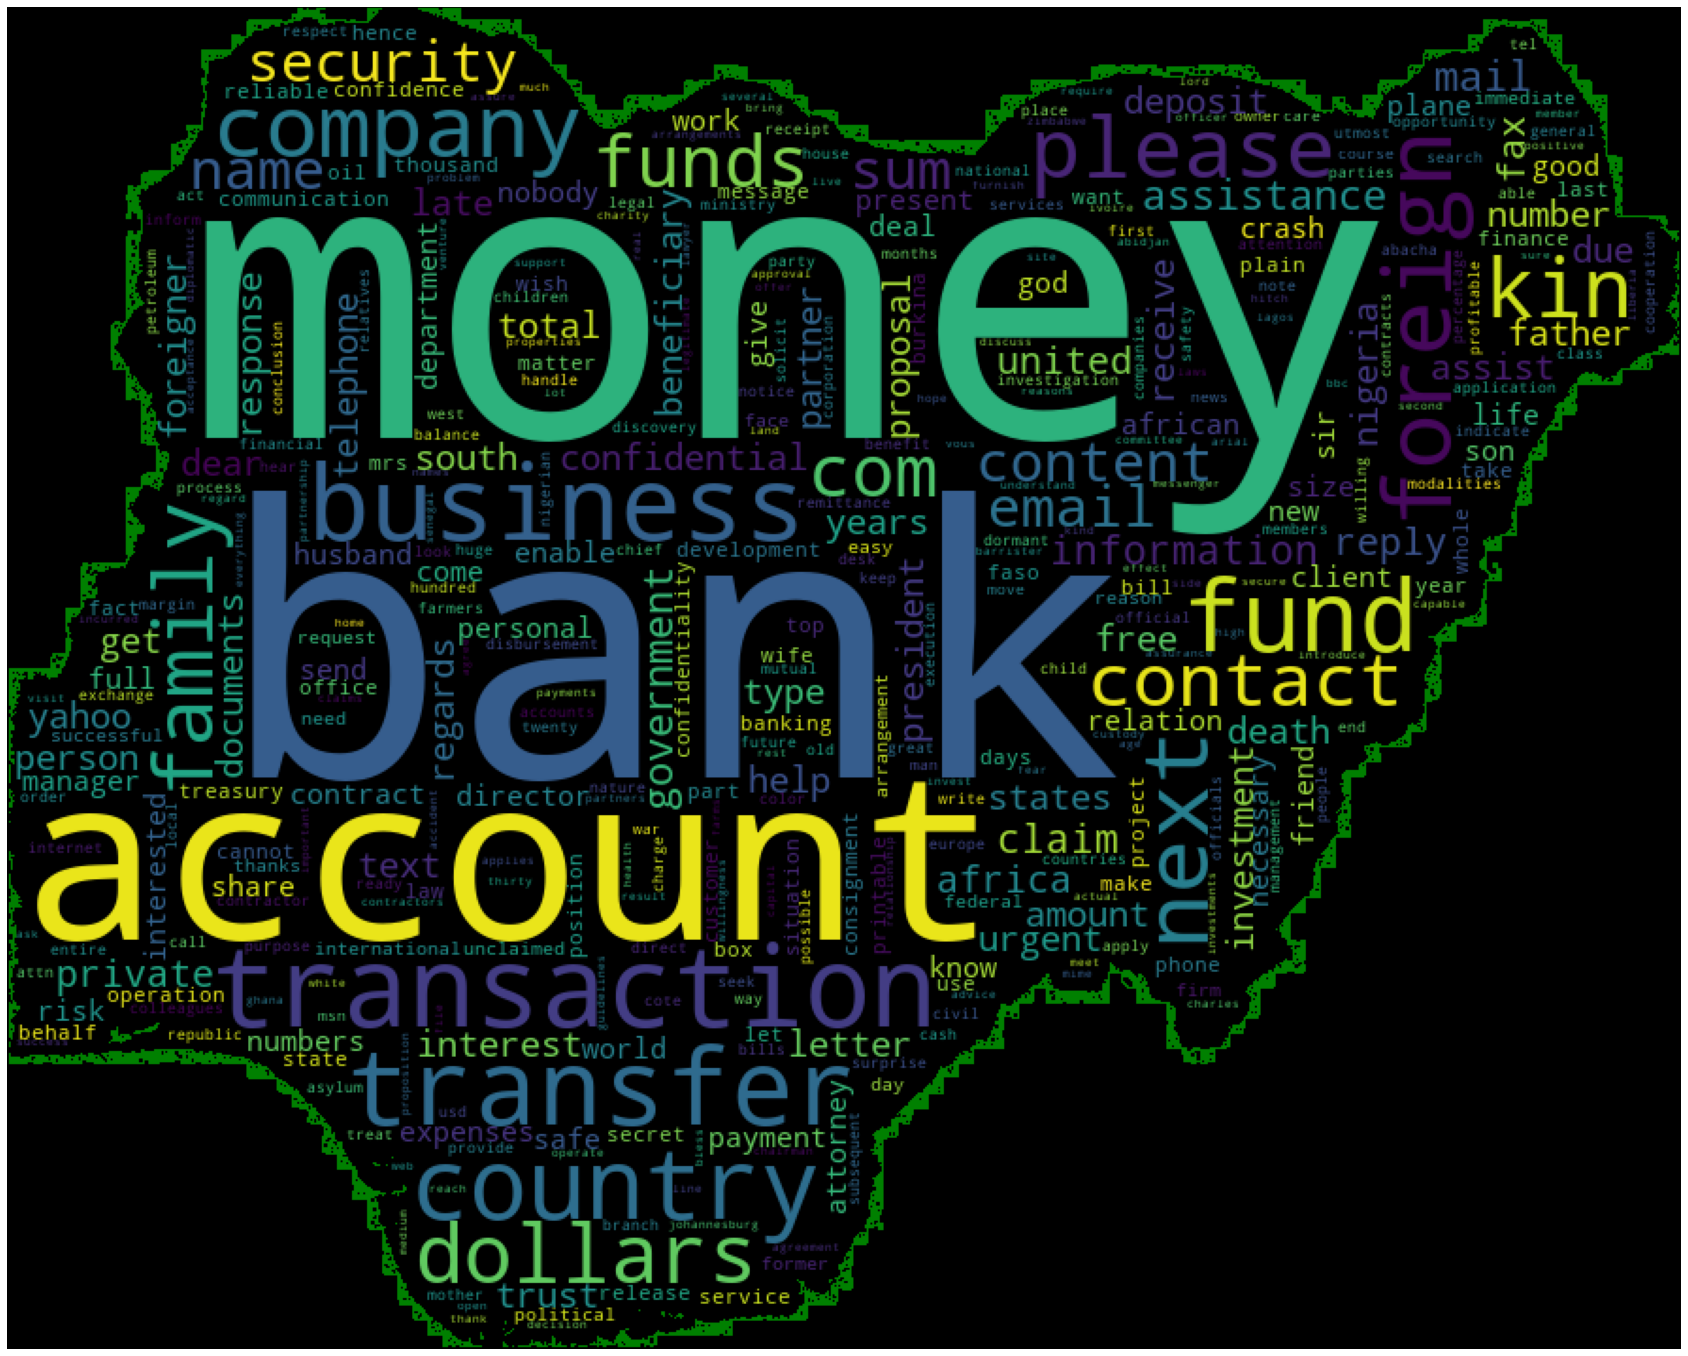

In [20]:
#Create image
plt.figure(figsize=(30,30))
plt.imshow(scamCloud)
plt.axis('off')
plt.savefig('../output/ScamWordCloud.png',bbox_inches='tight',pad_inches=0,dpi=133)


In [22]:
#Output formatted frequency
outputformatdf = pd.DataFrame.from_dict(scamDict, orient='index').sort_values(by=[0],ascending=False)
outputformatdf.to_csv('../output/WordFrequency_Processed.csv',header=False)
outputformatdf.head()

,0
money,4142
bank,3595
account,2856
transaction,2213
transfer,2006
